In [7]:
#exif2track - script to plot photo locations
import __future__
import sys
# argument parsing
import argparse
# glob for files
import glob
# file path tools
from os.path import join, basename
# regular expression
import re
# math library
import math
# Numpy
import numpy as np

# GDAL Python library
from osgeo import osr
# EXIF Reader
import exifread
# Image library
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# input arguments
#mydir = 'flight_2_nir_south_edited'
#mydir='flight_1_rgb_1'
#mydir='flight_1_rgb_2'
#mydir='flight_2_rgb_1'
#mydir='flight_2_nir_1'
mydir='test_images'
tdir = '2016-3-1_raptormaps_cape_cod'
tdir = ''

src_crs = 'EPSG:4326'
dst_crs = 'EPSG:26919'
filetype = 'JPG'

# construct filepath
filepath = join(tdir,mydir,'*.'+filetype)

# source coordinate system
srs_cs = osr.SpatialReference()
srs_cs.SetFromUserInput(src_crs)

# destination coordinate system
dst_cs = osr.SpatialReference()
dst_cs.SetFromUserInput(dst_crs)

# osr image transformation object
transform = osr.CoordinateTransformation(srs_cs, dst_cs)

# print coordinate system information
print " >> SOURCE COORDINATE REFERENCE SYSTEM: "
print srs_cs

print " >> DESTINATION COORDINATE REFERENCE SYSTEM: "
print dst_cs

 >> SOURCE COORDINATE REFERENCE SYSTEM: 
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
 >> DESTINATION COORDINATE REFERENCE SYSTEM: 
PROJCS["NAD83 / UTM zone 19N",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-69],
    PARAMETER["sca

In [8]:
"""Averge RGB color of image"""
def averageRGB(fpath):
    im = Image.open(fpath)
    h=np.array( im.histogram() )
    h=np.reshape(h,(3,256))

    rgb = np.zeros((1,3))
    wts = np.arange(0,254)
    for i in range(0,3):
        rgb[0,i] = sum(h[i,0:254]*wts)/sum(h[i,0:254])

    return rgb

""" Read GPS Files """
# return list of files with GPS data and print file stats
def getGPSFiles(filepath):
    files_gps = []
    files = sorted(glob.glob(filepath))
    n_images = len(files)
    n_images_GPS = 0
    for file in files:
        fs = open(file,'rb')

        # intialize arrays
        lat = []
        lon = []
        latref = []
        lonref = []
        alt = []
        time = []

        # attempt to read files
        try:
            tags = exifread.process_file(fs)
        except:
            print "No EXIF Data"
        try:  
            lon = tags['GPS GPSLongitude']
            lat = tags['GPS GPSLatitude']
            latref = tags['GPS GPSLatitudeRef']
            lonref = tags['GPS GPSLongitudeRef']
            alt = tags['GPS GPSAltitude']
            files_gps.append(file)
            n_images_GPS += 1
        except KeyError:
            print "No GPS Data for this image",file

        # Get time information primarily from GPSTimeStamp
        try:
            time = tags['GPS GPSTimeStamp']
        except KeyError:
            time = tags['EXIF DateTimeOriginal']
            print "No GPS Time Stamp for this image"
            
    # raise warning if no images have GPS data
    if n_images_GPS == 0:
        raise UserWarning('No images with GPS')
    else:
        print "Images with GPS: %d out of %d - %.2f%%" % (n_images_GPS, n_images, 100*n_images_GPS/n_images)
    
    return files_gps

""" Transform Coordinate System """
# return numpy array of flight path state [x y z t] in transformed coordinates
def transformCoordinateSystem(files):

    # initialize arrays
    flight_path_x = []
    flight_path_y = []
    flight_path_z = []
    flight_path_t = []
    flight_path_r = []
    flight_path_b = []
    flight_path_g = []

    # loop over files that have GPS data
    for file in files:
        fs = open(file,'rb')
        tags = exifread.process_file(fs)
        lon = tags['GPS GPSLongitude']
        lat = tags['GPS GPSLatitude']
        latref = tags['GPS GPSLatitudeRef']
        lonref = tags['GPS GPSLongitudeRef']
        alt = tags['GPS GPSAltitude']
        # handle time reading
        try:
            time = tags['GPS GPSTimeStamp']
            time_num = eval(str(time));
        except:
            time = tags['EXIF DateTimeOriginal']
            time_split = str(time).split()
            time  = time_split[1].split(':')
            time_num = [float(i) for i in time]
            
        # get average color
        rbg = np.zeros((1,3))
        try:
            rgb = averageRGB(file)
        except:
            print 'no color from ',file
                        
        alt_num = eval(str(alt))

        # convert time to seconds
        time_dec = (time_num[0]+time_num[1]/60.0 + time_num[2]/3600.0)*3600 # seconds

        ## Latitude
        # use regular expression to get value between brackets
        y_regx = re.search('\[(.*?)\]', str(lat))
        y_regx = y_regx.group(1)
        y_regx = y_regx.split(', ')
        # properly convert values to floats
        y = []
        y.append(eval(compile(y_regx[0],'<string>','eval', __future__.division.compiler_flag)))
        y.append(eval(compile(y_regx[1],'<string>','eval', __future__.division.compiler_flag)))
        y.append(eval(compile(y_regx[2],'<string>','eval', __future__.division.compiler_flag)))

        ## Longitude
        x_regx = re.search('\[(.*?)\]', str(lon))
        x_regx = x_regx.group(1)
        x_regx = x_regx.split(', ')
        x = []
        x.append(eval(compile(x_regx[0],'<string>','eval', __future__.division.compiler_flag)))
        x.append(eval(compile(x_regx[1],'<string>','eval', __future__.division.compiler_flag)))
        x.append(eval(compile(x_regx[2],'<string>','eval', __future__.division.compiler_flag)))
        
        # convert from latitude longitude minutes seconds to decimal
        ddx = (np.sign(x[0]))*(math.fabs(x[0]) + (x[1]/60.0) + (x[2]/3600.0))
        ddy = (np.sign(y[0]))*(math.fabs(y[0]) + (y[1]/60.0) + (y[2]/3600.0))

        # handle longitude west values to negative
        if str(lonref) == 'W':
            ddx = -1.0*ddx
        # handle latitude south values to negative
        if str(latref) == 'S':
            ddy = -1.0*ddy
            
        # get the coordinates in lat long
        # TransformPoint(X,Y) i.e. -> (long, lat)
        u = transform.TransformPoint(ddx, ddy)

        # append numpy arrays
        flight_path_x.append(u[0])
        flight_path_y.append(u[1])
        flight_path_z.append(alt_num)
        flight_path_t.append(time_dec)
        flight_path_r.append(rgb[0,0]/255.)
        flight_path_g.append(rgb[0,1]/255.)
        flight_path_b.append(rgb[0,2]/255.)

        # close connection to file
        fs.close()

    # build flight path matrix
    flight_path = np.array([flight_path_x, flight_path_y, flight_path_z, flight_path_t, flight_path_r, flight_path_g, flight_path_b])
    
    return flight_path

In [9]:

print " >> Read image files from ",filepath
files = getGPSFiles(filepath)
print " >> Transform coordinate system"
x = transformCoordinateSystem(files)
print " >> Flight path [x, y, z, t]"
print x

 >> Read image files from  test_images/*.JPG
Images with GPS: 29 out of 29 - 100.00%
 >> Transform coordinate system
 >> Flight path [x, y, z, t]
[[  4.21585830e+05   4.21594184e+05   4.21601416e+05   4.21608649e+05
    4.21612127e+05   4.21619216e+05   4.21622834e+05   4.21630774e+05
    4.21635230e+05   4.21644263e+05   4.21652328e+05   4.21656218e+05
    4.21663306e+05   4.21666501e+05   4.21783463e+05   4.21790293e+05
    4.21795572e+05   4.21798076e+05   4.21801284e+05   4.21807161e+05
    4.21812910e+05   4.21819479e+05   4.21823803e+05   4.21828407e+05
    4.21838593e+05   4.21844173e+05   4.21854489e+05   4.21863127e+05
    4.21866616e+05]
 [  4.63319177e+06   4.63314615e+06   4.63309907e+06   4.63305216e+06
    4.63302862e+06   4.63298117e+06   4.63295781e+06   4.63291219e+06
    4.63288957e+06   4.63284265e+06   4.63279574e+06   4.63277200e+06
    4.63272436e+06   4.63270027e+06   4.63180659e+06   4.63176043e+06
    4.63171170e+06   4.63168761e+06   4.63166463e+06   4.6316199

In [10]:
# calculate ground speed
eps = np.finfo(float).eps
dx=np.diff(x)
dist = np.sqrt( np.sum(dx[0:2,:]**2,axis = 0) )
dt = dx[3,:]
print np.mean(dist)
print np.mean(dt)
speed = dist/(dt+eps)
print np.mean(speed), np.max(speed), np.min(speed)


67.9403283129
2.89285714286
23.2985629007 24.5078910576 22.0575998799


(7, 29) (2, 29) (3, 29)
[ 0.57647059  0.64313725  0.54117647]


/home/csherwood/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


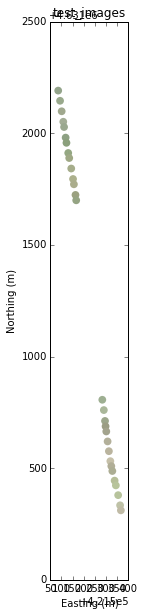

In [11]:
# plot UTM x,y with average image color
rgb = x[4:7,:]
print np.shape(x), np.shape(x[4:6,:]), np.shape(rgb)
print x[4:7,0]
#rgb = np.array((0.5, 0.5, 0.5))
ss = np.ones_like(x[1,:])*20.
fig,ax = plt.subplots(figsize=(8,10))
for i in range(len(x[0,:])):
    ax.scatter(x[0,i],x[1,i],s=60,c=rgb[:,i],edgecolors='none')
    
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title(mydir)
#plt.xlim(4206000,422200)
#plt.ylim(4630000,4634000)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.savefig(mydir+'.png')